In [14]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [15]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()

In [16]:
X_valid, y_valid = X_train_full[:5000]/255.0, y_train_full[:5000]
X_train, y_train = X_train_full[5000:]/255.0, y_train_full[5000:]
X_test = X_test / 255.0

In [17]:
import os
from time import strftime, gmtime

In [18]:
def get_board_path(name: str = ""):
    return os.path.join(".", "tensorboard", strftime("%Y-%m-%d_%H:%M:%S", gmtime())+"_"+ name)

### Simple Model

In [19]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    keras.layers.Dense(units=784, activation="relu"),
    keras.layers.Dense(units=523, activation="relu"),
    keras.layers.Dense(units=260, activation="relu"),
    keras.layers.Dense(units=130, activation="tanh"),
    keras.layers.Dense(units=50, activation="tanh"),
    keras.layers.Dense(units=10, activation="softmax")
])

In [20]:
model.save_weights("simple_init.h5")

In [21]:
tensorboard_cb = keras.callbacks.TensorBoard(log_dir=get_board_path("simple"))
early_stop_cb = keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)

In [22]:
model.compile(optimizer=keras.optimizers.SGD(learning_rate=0.01), loss=keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])

In [11]:
model.fit(x=X_train, y=y_train, validation_data=(X_valid, y_valid), callbacks=[tensorboard_cb, early_stop_cb], epochs=50, batch_size=32)

Epoch 1/50
1719/1719 [==============================] - 8s 5ms/step - loss: 0.5099 - accuracy: 0.8747 - val_loss: 0.2229 - val_accuracy: 0.9396
Epoch 2/50
1719/1719 [==============================] - 11s 6ms/step - loss: 0.1961 - accuracy: 0.9449 - val_loss: 0.1504 - val_accuracy: 0.9552
Epoch 3/50
1719/1719 [==============================] - 9s 5ms/step - loss: 0.1378 - accuracy: 0.9610 - val_loss: 0.1257 - val_accuracy: 0.9644
Epoch 4/50
1719/1719 [==============================] - 8s 5ms/step - loss: 0.1064 - accuracy: 0.9693 - val_loss: 0.1023 - val_accuracy: 0.9714
Epoch 5/50
1719/1719 [==============================] - 8s 5ms/step - loss: 0.0846 - accuracy: 0.9761 - val_loss: 0.1014 - val_accuracy: 0.9692
Epoch 6/50
1719/1719 [==============================] - 8s 5ms/step - loss: 0.0679 - accuracy: 0.9812 - val_loss: 0.0911 - val_accuracy: 0.9714
Epoch 7/50
1719/1719 [==============================] - 9s 5ms/step - loss: 0.0556 - accuracy: 0.9856 - val_loss: 0.0800 - val_accuracy

continue training with a lower learning rate.

In [23]:
keras.backend.set_value(model.optimizer.learning_rate, 0.001)

In [12]:
model.fit(x=X_train, y=y_train, validation_data=(X_valid, y_valid), callbacks=[tensorboard_cb, early_stop_cb], epochs=50, batch_size = 32)

Epoch 1/50
1079/1719 [=================>............] - ETA: 3s - loss: 1.8209 - accuracy: 0.5515

KeyboardInterrupt: 

### Finding the Optimal Learning Rate

In [85]:
model.load_weights("./simple_init.h5")

In [86]:
keras.backend.set_value(model.optimizer.learning_rate, 0.001)

In [87]:
class LearningRateInc(keras.callbacks.Callback):
    def __init__(self, factor: float):
        super(LearningRateInc, self)
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_train_batch_end(self, batch, logs):
        if not hasattr(self.model.optimizer, "lr"):
            raise ValueError("learning rate attribute is not reachable")
        curr_lr = keras.backend.get_value(self.model.optimizer.lr)
        new_lr = self.factor * curr_lr
        keras.backend.set_value(self.model.optimizer.lr, new_lr)
        self.rates.append(curr_lr)
        self.losses.append(logs["loss"])
        # print(", batch: {}, lr: {}, next lr: {}".format(batch, curr_lr, new_lr))
    def on_train_epoch_end(self, logs):
        print(", current lr: {}".format(keras.backend.get_value(self.model.optimizer.lr)))

In [88]:
import math

In [89]:
lr_inc_cb = LearningRateInc(math.exp(math.log10(10**6)/500))

In [90]:
model.fit(x = X_train, y= y_train, callbacks=[lr_inc_cb], epochs=1)

1719/1719 [==============================] - 7s 4ms/step - loss: 11.6376 - accuracy: 0.5990


In [91]:
max(lr_inc_cb.rates)

5.2637386

In [92]:
min(lr_inc_cb.losses)

0.9657799601554871

Text(0, 0.5, 'Loss')

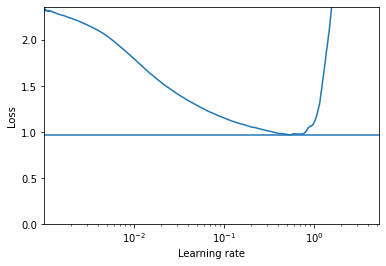

In [93]:
plt.plot(lr_inc_cb.rates, lr_inc_cb.losses)
plt.gca().set_xscale('log')
plt.hlines(min(lr_inc_cb.losses), min(lr_inc_cb.rates), max(lr_inc_cb.rates))
plt.axis([min(lr_inc_cb.rates), max(lr_inc_cb.rates), 0, lr_inc_cb.losses[0]])
plt.xlabel("Learning rate")
plt.ylabel("Loss")

In [95]:
model.load_weights("./simple_init.h5")
keras.backend.set_value(model.optimizer.lr, 0.7)

In [96]:
tensorboard_cb = keras.callbacks.TensorBoard(log_dir=get_board_path("simple"))
early_stop_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
model.fit(x=X_train, y=y_train, validation_data=(X_valid, y_valid), callbacks=[tensorboard_cb, early_stop_cb], epochs=50, steps_per_epoch=1000)

Epoch 1/50
1000/1000 [==============================] - 5s 5ms/step - loss: 0.4439 - accuracy: 0.8651 - val_loss: 0.1542 - val_accuracy: 0.9566
Epoch 2/50
1000/1000 [==============================] - 5s 5ms/step - loss: 0.1320 - accuracy: 0.9617 - val_loss: 0.1118 - val_accuracy: 0.9686
Epoch 3/50
1000/1000 [==============================] - 6s 6ms/step - loss: 0.0898 - accuracy: 0.9729 - val_loss: 0.0963 - val_accuracy: 0.9762
Epoch 4/50
1000/1000 [==============================] - 6s 6ms/step - loss: 0.0674 - accuracy: 0.9804 - val_loss: 0.0830 - val_accuracy: 0.9760
Epoch 5/50
1000/1000 [==============================] - 5s 5ms/step - loss: 0.0513 - accuracy: 0.9847 - val_loss: 0.0781 - val_accuracy: 0.9802
Epoch 6/50
1000/1000 [==============================] - 5s 5ms/step - loss: 0.0391 - accuracy: 0.9879 - val_loss: 0.0859 - val_accuracy: 0.9786
Epoch 7/50
1000/1000 [==============================] - 5s 5ms/step - loss: 0.0342 - accuracy: 0.9894 - val_loss: 0.0957 - val_accuracy: